In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras.preprocessing import image
import os
import cv2

## Data Preparation :-

In [2]:
# 1. creating directories for storing training, testing and validation data in resp class_names subdirectories
# 2. prepare_data reads images, converts into suitable scale and flips them if needed (in case of training data) and saves them.
# 3. train_cnt == # training data points
# 4. val_cnt = # val_data data points (images)
# Rest will be testing data

os.makedirs('images/training/covid',exist_ok = True)
os.makedirs('images/training/normal',exist_ok = True)
os.makedirs('images/testing/covid',exist_ok = True)
os.makedirs('images/testing/normal',exist_ok = True)
os.makedirs('images/validation/covid',exist_ok = True)
os.makedirs('images/validation/normal',exist_ok = True)

def prepare_data(pre,des,train_cnt,val_cnt):
    for file in os.listdir(pre+'/images'):
        
        image = cv2.resize(cv2.imread(pre+'/images/'+file),(256,256))
        mask = cv2.resize(cv2.imread(pre+'/masks/'+file),(256,256))
        image *= mask
        
        if(train_cnt > 0) : 
            cv2.imwrite('images/training/'+des+'/'+file,image)
            if(des == 'covid') : cv2.imwrite('images/training/'+des+'/flipped_'+file,image[:,::-1,:])
            train_cnt -= 1
        elif (val_cnt > 0):
            cv2.imwrite('images/validation/'+des+'/'+file,image)
            if(des == 'covid') : cv2.imwrite('images/validation/'+des+'/flipped_'+file,image[:,::-1,:])
            val_cnt -= 1
        else:
            cv2.imwrite('images/testing/'+des+'/'+file,image)
            if(des == 'covid') : cv2.imwrite('images/testing/'+des+'/flipped_'+file,image[:,::-1,:])

pre = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset'

train_cnt = len(os.listdir(pre+'/COVID/images'))
val_cnt = train_cnt*(0.15)
train_cnt -= 2*val_cnt
prepare_data(pre+'/COVID','covid',train_cnt,val_cnt)
               
train_cnt = len(os.listdir(pre+'/Normal/images'))
val_cnt = train_cnt*(0.15)
train_cnt -= 2*val_cnt
prepare_data(pre+'/Normal','normal',train_cnt,val_cnt)

In [3]:
# Printing Total size of covid & normal dataset resp.

print(len(os.listdir('images/training/covid')),len(os.listdir('images/training/normal')))
print(len(os.listdir('images/validation/covid')),len(os.listdir('images/validation/normal')))
print(len(os.listdir('images/testing/covid')),len(os.listdir('images/testing/normal')))

5064 7135
1086 1529
1082 1528


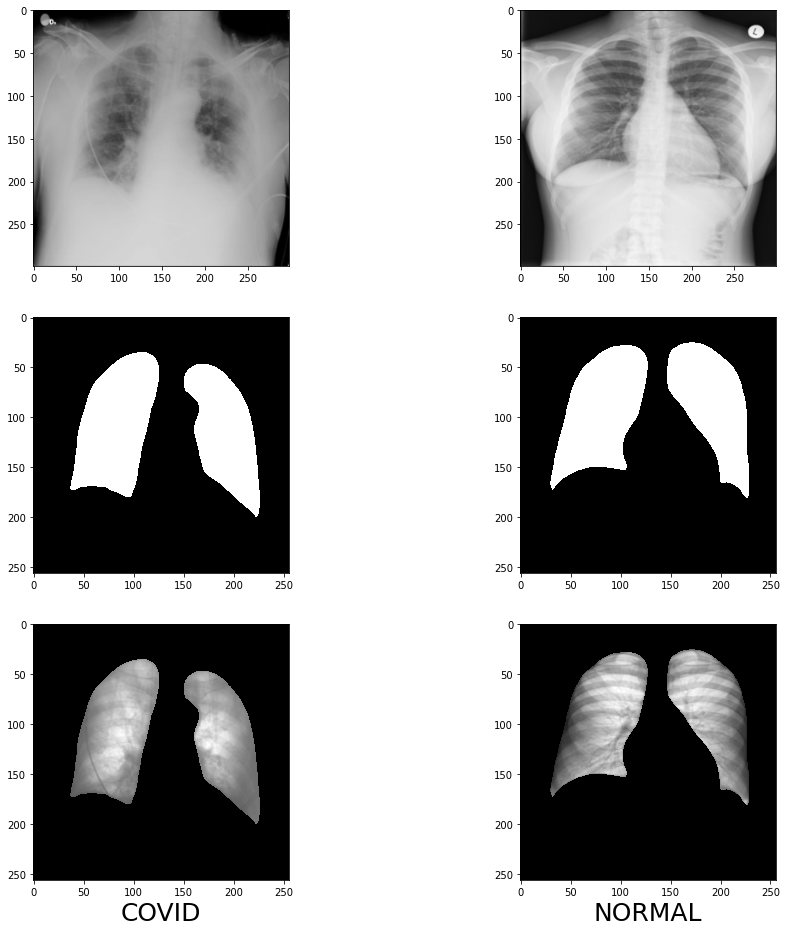

In [4]:
covid = cv2.imread('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png',cv2.IMREAD_GRAYSCALE)
covid_mask = cv2.imread('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/masks/COVID-1.png',cv2.IMREAD_GRAYSCALE)
covid1 = cv2.imread('images/training/covid/COVID-1.png',cv2.IMREAD_GRAYSCALE)

normal = cv2.imread('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-2.png',cv2.IMREAD_GRAYSCALE)
normal_mask = cv2.imread('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks/Normal-2.png',cv2.IMREAD_GRAYSCALE)
normal1 = cv2.imread('images/training/normal/Normal-2.png',cv2.IMREAD_GRAYSCALE)

plt.figure(figsize = (16,16))
plt.subplot(3,2,1)
plt.imshow(covid,cmap = 'gray')
plt.subplot(3,2,2)
plt.imshow(normal,cmap = 'gray')
plt.subplot(3,2,3)
plt.imshow(covid_mask,cmap = 'gray')
plt.subplot(3,2,4)
plt.imshow(normal_mask,cmap = 'gray')
plt.subplot(3,2,5)
plt.imshow(covid1,cmap = 'gray')
plt.xlabel('COVID',fontdict = {'size':25})
plt.subplot(3,2,6)
plt.imshow(normal1,cmap = 'gray')
plt.xlabel('NORMAL',fontdict = {'size':25})
plt.show()

## Creating model :-

In [5]:
# Building model 
# input shape (256,256,1) => cubic dimension, 2D image, 1 channels(1 unit - deapth)
# Model should be provided grayscale images

def build_model():
    input_layer = keras.Input(shape = (256,256,1)) 
    
    x = layers.Rescaling(1/255.)(input_layer)
    
    x = layers.Conv2D(64,(3,3),activation='relu',name = 'conv2d_2')(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(0.5)(x)
    # randomly dropping some training points

    x = layers.Conv2D(128,(3,3),activation='relu',name = 'conv2d_3')(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(256,(3,3),activation='relu',name = 'conv2d_4')(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(32,activation='relu',name = 'dense_1')(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(1,activation='sigmoid',name = 'dense_2')(x)

    return keras.Model(input_layer,output_layer,name = 'model')

In [6]:
model = build_model()

2022-06-27 18:27:22.010942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 18:27:22.124542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 18:27:22.125293: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 18:27:22.126993: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 254, 254, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 128)       0     

In [8]:
# creating data generators

train_gen = image.ImageDataGenerator()
train_ds = train_gen.flow_from_directory(
    'images/training',
    target_size = (256,256),
    batch_size = 128,
    class_mode = 'binary',
    color_mode = 'grayscale'
)

val_gen = image.ImageDataGenerator()
val_ds = val_gen.flow_from_directory(
    'images/validation',
    target_size = (256,256),
    batch_size = 128,
    class_mode = 'binary',
    color_mode = 'grayscale'
)

Found 12199 images belonging to 2 classes.
Found 2615 images belonging to 2 classes.


In [9]:
model.compile(loss = 'binary_crossentropy',optimizer = 'Adam',metrics = ['accuracy'])

history = model.fit_generator(
    train_ds,
    validation_data = val_ds,
    epochs = 30,
)


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-06-27 18:27:26.280650: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-06-27 18:27:28.190109: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


96/96 [==============================] - 46s 373ms/step - loss: 0.6945 - accuracy: 0.6785 - val_loss: 0.5942 - val_accuracy: 0.7621
Epoch 2/30
96/96 [==============================] - 33s 345ms/step - loss: 0.5790 - accuracy: 0.7730 - val_loss: 0.5476 - val_accuracy: 0.7973
Epoch 3/30
96/96 [==============================] - 33s 344ms/step - loss: 0.5457 - accuracy: 0.7928 - val_loss: 0.4320 - val_accuracy: 0.8210
Epoch 4/30
96/96 [==============================] - 34s 348ms/step - loss: 0.4296 - accuracy: 0.8207 - val_loss: 0.3629 - val_accuracy: 0.8463
Epoch 5/30
96/96 [==============================] - 34s 350ms/step - loss: 0.3803 - accuracy: 0.8469 - val_loss: 0.3833 - val_accuracy: 0.8570
Epoch 6/30
96/96 [==============================] - 34s 348ms/step - loss: 0.3586 - accuracy: 0.8583 - val_loss: 0.3203 - val_accuracy: 0.8627
Epoch 7/30
96/96 [==============================] - 33s 347ms/step - loss: 0.3401 - accuracy: 0.8629 - val_loss: 0.3435 - val_accuracy: 0.8711
Epoch 8/30

In [10]:
train_ds.class_indices , val_ds.class_indices

({'covid': 0, 'normal': 1}, {'covid': 0, 'normal': 1})

In [11]:
xtest = []
ytest = []

for file in os.listdir('images/testing/covid'):
    image = cv2.imread('images/testing/covid/'+file,cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image,(256,256))
    xtest.append(image)
    ytest.append(0)
    
for file in os.listdir('images/testing/normal'):
    image = cv2.imread('images/testing/normal/'+file,cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image,(256,256))
    xtest.append(image)
    ytest.append(1)
    
xtest = np.array(xtest)
ytest = np.array(ytest).reshape(-1,1)

In [12]:
# predicting classes on xtest images and then
# sigmoid gives final output as close to 0 or 1 (not exactly 0 or 1)
# so converting them into 0 or 1 on the basis of closeness

ypred = (model.predict(xtest) > 0.5)*1

In [13]:
# Finding accuracy on testing data

correct_pred = (ytest == ypred).sum()
print(100*correct_pred/(ytest.shape[0]))

89.3103448275862


### It can differentiate between a normal and a covid infected lung with 90% accuracy